# Fair Machine Learning Utilizing Causal Inference

In the notebook, we reproduce the results from the paper, [Counterfactual Fairness](https://arxiv.org/pdf/1703.06856v3.pdf) by Kusner et al. 

Machine learning (ML) is a powerful tool with numerous uses across varying fields. It can be applied in tasks such as filtering out spam from emails, detecting credit card fraud, converting your speech into text and many more. There are also fields of like credit scoring, crime prediction, and loan assessment that contain latent bias. These data sets when used for decision making can contain bias due to historical prejudice. This poses a challenge for statistician to ensure their models do not perpetuate discrimination. 

The authors advocate for a fair algorithm, introducting Counterfactual Fairness. This framework builds on Pearl's causal framework, using causal diagrams and counterfactuals to understand biases in data. The authors propose a model where predictors are counterfactually fair if they yield the same distribution under hypothetical changes (counterfactuals) in protected attributes. 

They apply this concept to a law school success prediction case study, comparing their approach to traditional models and demonstrate that counterfactual fairness offers a more robust mechanism for addressing biases inherent in predictive algorithms. 


### Background


#### Notation
A - set of protected attributes of an individual

X - any other observable attributes of an individual

U - set of relevant latent attributes which are not observed

Y - outcome to be predicted (may be contaminated with historical biases)

$\hat{Y}$ - predictors, RV that depends on A, X, U


#### Fairness

Previous research has defined fairness in the past through various algorithms: 

1. **Fairness Through Unawareness**: An algorithm is fair as long as the protected attributes are not used in the decision making process

2. **Individual Fairness**: An algorithm is fair if similar individuals receive similar predictions
    - $\hat{Y}(X^{(i)},A^{(i)}) \approx \hat{Y}(X^{(j)},A^{(j)})$
    - Two individuals are similar according to a metric $d(i,j)$ which will measure the similarity between the individuals
3. **Demographic Parity**: An algorithm is fair if prediction rates are equal across protected groups
4. **Equality of Opportunity**: An algorithm is fair if prediction rates are equal across those who meet a certain criteria

These all lack a relationship between all attributes and do not adequately address historical biases.

**Counterfactual Fairness**: A predictor $\hat{Y}$ is counterfactually fair, if for any context $X = x$ and $A = a$, the distribution of $\hat{Y}$ remains the same even if we hypothetically change $A$ to any other attainable value $a'$

$$ 
P(\hat{Y}_{A \leftarrow a}(U) = y | X = x, A = a) = P(\hat{Y}_{A \leftarrow a'}(U) = y | X = x, A = a)
$$


**Lemma**:  A predictor $\hat{Y}$ is CF if it's a function of variables not causally downstream of the protected attribute A. 



### Modeling

The authors propose 4 models: 

#### Unfair Models

1. **Full**: standard technique of using all features

2. **Unaware**: FTU, where one doesn't use any protected attribute

#### Fair models

There are 3 ways to model a CF predictor, each increasing assumption strength

**Level 1**: Uses observable variables not caused by protected attributes. Because this includes descendant of protected attributes, we cannot model level 1. We believe LSAT, GPA, FYA to be biased by Race and Sex.

**Level 2**: Models latent 'fair' variables which are parents of the observed variables. These are independent of both race and sex. 

**Level 3**: Models the data using an additive error model and uses the independent error terms to make predictions.


In [1]:
# import libraries
import os
import pickle
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

# probability and modeling
import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from utils import FairKModel
from utils import FairKModelTest
from utils import FairKModelTest2

In [2]:
# loading data
base_path = 'Fair-ML-Causal-Inference'
law_path = os.path.join('~', base_path, 'data', 'law_data.csv')
data = pd.read_csv(law_path)

data.head()

,Unnamed: 0,race,sex,LSAT,UGPA,region_first,ZFYA,sander_index,first_pf
0,0,White,1,39.0,3.1,GL,-0.98,0.782738,1.0
1,1,White,1,36.0,3.0,GL,0.09,0.735714,1.0
2,2,White,2,30.0,3.1,MS,-0.35,0.670238,1.0
3,5,Hispanic,2,39.0,2.2,NE,0.58,0.697024,1.0
4,6,White,1,37.0,3.4,GL,-1.26,0.786310,1.0


### Prepping Data

Remove any problem observations and select features the researchers used

In [3]:
# remove observations low sample size observations
display(data['region_first'].value_counts())
data = data.loc[data['region_first'] != 'PO']

region_first
NE    4302
GL    3822
FW    2904
SE    2651
MS    2346
SC    2251
Mt    1147
NG    1133
MW    1071
NW     163
PO       1
Name: count, dtype: int64

In [5]:
# keep features used by researchers
cols_keep = ['race', 'sex', 'LSAT', 'UGPA', 'ZFYA'] 
law_data = data[cols_keep]
law_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21790 entries, 0 to 21790
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   race    21790 non-null  object 
 1   sex     21790 non-null  int64  
 2   LSAT    21790 non-null  float64
 3   UGPA    21790 non-null  float64
 4   ZFYA    21790 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1021.4+ KB


### OHE

One Hot Encode the categorical data so it can be used for regression

In [6]:
# visualize the distributions for our OHE features
display(law_data['race'].value_counts(), law_data['sex'].value_counts())

# convert sex to category
law_data.loc[:,'sex'] = np.where(law_data['sex'] == 1, 'Female', 'Male')

race
White          18284
Black           1282
Asian            845
Hispanic         488
Mexican          389
Other            293
Puertorican      110
Amerindian        99
Name: count, dtype: int64

sex
2    12253
1     9537
Name: count, dtype: int64

In [7]:
# split the data first to avoid data leakage
train, test = train_test_split(law_data, train_size=0.8, random_state=256)

# explicit categories and their unique values
categories = [('sex', list(law_data['sex'].unique())),
              ('race', list(law_data['race'].unique()))]

# denote column name and the unique categories as variables
ohe_columns = [x[0] for x in categories]
ohe_categories = [x[1] for x in categories]

# initialize OHE
enc = OneHotEncoder(sparse=False, categories=ohe_categories, )

# fit and transform the train
train_trans = pd.DataFrame(
    enc.fit_transform(train[ohe_columns]),
    columns = enc.get_feature_names_out(),
    index = train.index
)
# concatenate transformed cols with non transformed
train_trans = pd.concat([train.drop(ohe_columns, axis=1), train_trans], axis=1).reset_index(drop=True)
# remove the prefix the default encoding gives
train_trans.columns = [col.split('_')[1] if '_' in col else col for col in train_trans.columns]

# apply same transformation to test data
test_trans = pd.DataFrame(
    enc.fit_transform(test[ohe_columns]),
    columns = enc.get_feature_names_out(),
    index = test.index
)
# concetenate trans cols with non trans, reset index
test_trans = pd.concat([test.drop(ohe_columns, axis=1) ,test_trans], axis=1).reset_index(drop=True)
test_trans.columns = [col.split('_')[1] if '_' in col else col for col in test_trans.columns]


/accounts/grad/khern045/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/accounts/grad/khern045/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# round data to whole numbers to prep it for Poisson (only accepts integers)
train_trans['LSAT'] = train_trans['LSAT'].round()
test_trans['LSAT'] = test_trans['LSAT'].round()

# convert to tensors so its compatible with pytorch
X_train, y_train = torch.tensor(train_trans.drop(['ZFYA'], axis=1).values, dtype=torch.float32), torch.tensor(train_trans['ZFYA'], dtype=torch.float32) 
X_test, y_test = torch.tensor(test_trans.drop(['ZFYA'], axis=1).values, dtype=torch.float32), torch.tensor(test_trans['ZFYA'], dtype=torch.float32) 

### Linear Model

In [9]:
# object to allow use of dataloader
class Dataset(torch.utils.data.Dataset):
     def __init__(self, dataframe):
          self.dataframe = dataframe
      
     def __len__(self):
          return self.dataframe.shape[0]
     
     def __getitem__(self, idx):
          x = torch.tensor(self.dataframe.drop(['ZFYA'], axis=1).loc[idx,:].values, dtype=torch.float32)
          y = torch.tensor(self.dataframe.loc[idx, 'ZFYA'], dtype=torch.float32)
          return x,y

In [10]:
# class inherits form a class called nn.Module
class LinearRegressionModel(nn.Module):
    # initialization method for new class
    def __init__(self, input_size, output_size):
        # first thing always do is call initialization method from the parent class, nn.module
        super().__init__()

        # fully connected linear layer
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        # run the linear layer
        output = self.fc1(x)

        return output
    
# evaluate models performance
def evaluate(model, X_train, y_test):
    # Make predictions
    with torch.no_grad(): # disable gradient computation
        predictions = model(X_train).squeeze()

    # Calculate RMSE
    mse = torch.nn.functional.mse_loss(predictions, y_test)
    rmse = np.sqrt(mse.item())

    return rmse

def train(network, train_dataset, test_dataset, file_name_model, n_epochs=10, batch_size = 25):
    assert isinstance(file_name_model, str), "The filename is not a string"
    
    data_loader = torch.utils.data.DataLoader(Dataset(train_dataset), batch_size = batch_size, shuffle=True)
    
    X_test = torch.tensor(test_dataset.drop(['ZFYA'], axis=1).values, dtype=torch.float32)
    y_test = torch.tensor(test_dataset['ZFYA'], dtype=torch.float32)
    
    # Move network to GPU if available
    network = network.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # define optimizer
    optimizer = torch.optim.Adam(network.parameters())

    # best validation score initialization 
    validation_score_best = float('inf')
    train_losses = []
    validation_scores = []

    # train loop
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in tqdm(data_loader, leave=False):
            # unpack batch
            X, y = batch

            # zero parameter gradients
            optimizer.zero_grad()
            
            # forward pass to get input
            # output is of shape [20,1] but we want of size [20] to compare 
            output = network(X).squeeze()

            # calculate loss
            loss = nn.MSELoss()(output, y)
            epoch_loss += loss.item()
            # root_loss = torch.sqrt(loss)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step() # update model parameters
        
        avg_epoch_loss = epoch_loss / len(data_loader)  # Average loss per epoch
        train_losses.append(avg_epoch_loss)  # Append average epoch loss
        
        validation_score = evaluate(network, X_test, y_test) # evaluation mode
        validation_scores.append(validation_score)
        if epoch % 5 == 0:
            print(f'Epoch {epoch+1}, validation score: {validation_score}')
        network.train() # back to train mode

        if validation_score < validation_score_best:
            validation_score_best = validation_score
            torch.save(network.state_dict(), os.path.join('../model', file_name_model+'.pt')) 
            
    print(f'Best validation score:{validation_score_best}')
    return validation_scores, train_losses

### Full Model

Implements the unfair full model which includes all features

In [12]:
# create and train model
data_dir = '../data'
model_dir = '../models'
full_model = LinearRegressionModel(train_trans.shape[1]-1, 1)
full_model.load_state_dict(torch.load(os.path.join(model_dir, 'full_model.pt')))
# full_validation_scores, full_train_losses = train(full_model, train_trans, test_trans, 'full_model', n_epochs=15, batch_size=20)

<All keys matched successfully>

In [13]:
categories = [item for items in ohe_categories for item in items]
categories

['Female',
 'Male',
 'White',
 'Hispanic',
 'Asian',
 'Black',
 'Other',
 'Mexican',
 'Puertorican',
 'Amerindian']

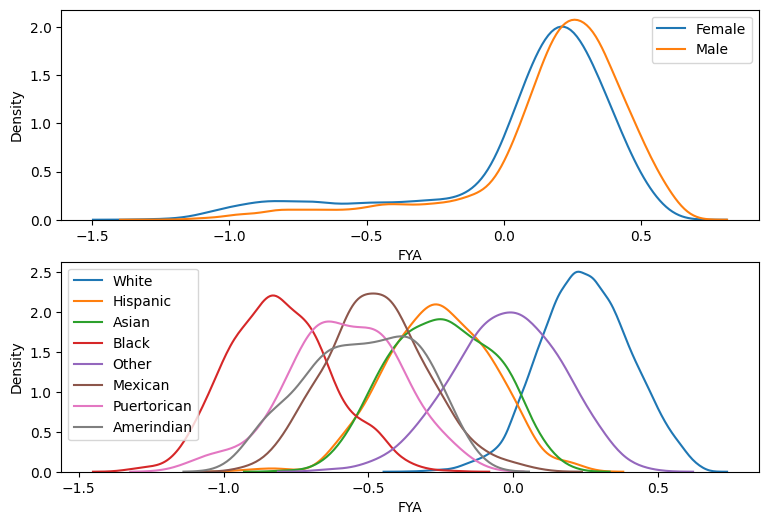

In [14]:

train_tensor = torch.tensor(train_trans.values, dtype=torch.float32)
test_tensor = torch.tensor(test_trans.values, dtype=torch.float32)

# Look at distribution of FYA on difference races and sex on train set
fit = train_trans.copy()
fit['FYA'] = full_model(X_train).detach().numpy()

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(9, 6)

for column in ohe_categories[0]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax1)
ax1.legend()

for column in ohe_categories[1]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax2)

ax2.legend()

plt.show()


### Unaware Model

Implements the FTU model 

In [15]:
protected_attributes = ['Female', 'Male', 'White', 'Hispanic', 'Asian', 'Black', 'Other', 'Mexican', 'Puertorican', 'Amerindian']

train_unaware = train_trans.drop(protected_attributes, axis=1)
test_unaware = test_trans.drop(protected_attributes, axis=1)

unaware_model = LinearRegressionModel(train_unaware.shape[1]-1, 1)
unaware_model.load_state_dict(torch.load(os.path.join(model_dir,'unaware_model.pt')))
# unaware_validation_scores, unaware_train_losses = train(unaware_model, train_unaware, test_unaware, 'unaware_model', n_epochs=15, batch_size=20)

<All keys matched successfully>

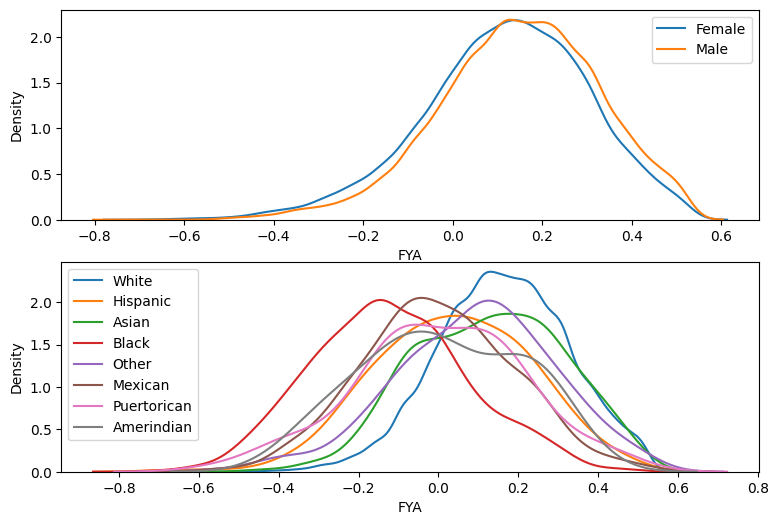

In [16]:

# Look at distribution of FYA on difference races and sex on train set
fit = train_trans.copy()
fit['FYA'] = unaware_model(torch.tensor(train_unaware.drop('ZFYA', axis=1).values, dtype=torch.float32)).detach().numpy()

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(9, 6)

for column in ohe_categories[0]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax1)
ax1.legend()

for column in ohe_categories[1]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax2)

ax2.legend()

plt.show()

### Fair K

Fair K introduces a background latend variables, K, which are not decendants of protected demographic factors. Information about X is passed to $\hat{Y}$ via $P(K|x,a)$

If we can't calculate P_M(K|x,a) analytically use the following algorithm:



START Procedure FAIRLEARNING($D,M$)

1. For each datapoint $i \in D$, sample $m$ MCMC samples $K_1^{(i)}, \cdots, K_1^{(i)} \sim P_M(K | x^{(i)}, a^{(i)})$
2. Let $D'$ be the augmentd dataset where each ponit $(a^{(i)}, x^{(i)}, y^{(i)})$ in $D$ is replaced with the corresponding $m$ points ${ (a^{(i)}, x^{(i)}, y^{(i)}, k_j^{(i)}) }$
3. $\hat{\theta} \leftarrow argmin_\theta \sum_{i’ \in D’} l(y^{(i’)}, g_\theta(K^{(i’)}, x^{(i’)}_{\ A}))$

END procedure


To solve 1 of the FAIRLEARNING we can use bayes $P(A|B) = P(B|A)P(A) / P(B)$. 

In our scenario, $P(K∣GPA,LSAT,FYA,Race,Sex)$ is the posterior distribution of $K$. 

$P(GPA,LSAT,FYA∣K,Race,Sex)$ is the likelihood of observing the data given $K$. 

$P(K)$ is the prior distribution of $K$, representing our beliefs about $K$ before observing the data. 

$P(GPA,LSAT,FYA,Race,Sex)$ is the evidence, or the probability of observing the data under all possible values of $K$.

We can then sample from our posterior using MCMC




In the FAIRLEARNING algorithm, the augmented dataset {(a(i),x(i),y(i),uj(i))} includes all these variables, but the key aspect is how they are used. The model g_\theta(U(i),xA(i))typically uses the inferred latent variables U(i) (in this case, K values from K_list_train) and the non-protected attributes A(i)​ to predict the outcome Y. The protected attributes A (like race and sex in your model) are not directly used in the prediction to ensure fairness; instead, their effect is mediated through the latent variables. This approach aims to make predictions based on factors like knowledge while accounting for potential biases in the observed data.

In [65]:
from utils import FairKModel

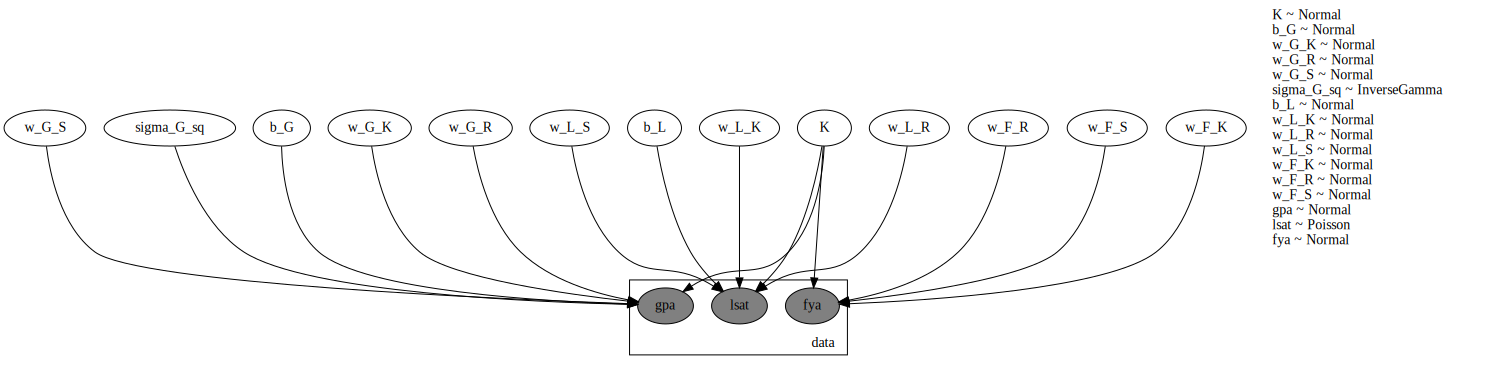

In [39]:
# structure of FairKModel
# generates a DAG of the model, showing how different rvs are related to each other within the model
model_graph = pyro.render_model(
    FairKModel, 
    model_args=(train_tensor[:,5:], train_tensor[:,3:5], train_tensor.shape[0], 
                law_data, train_tensor[:,1], train_tensor[:,0], train_tensor[:,2]),
    render_distributions=True, 
    render_params=True
    )
model_graph

In [66]:


values_reestimate = ['b_G', 'w_G_R', 'w_G_S', 'w_G_K', 'sigma_G_sq', 'b_L', 'w_L_R', 'w_L_S', 'w_L_K']

K_list_train = []
reestimated_params = {param: [] for param in values_reestimate}
metrics_train = {'ESS_values':[], 'normalized_weights':[]}

for i in tqdm(range(train_tensor.shape[0])):
        # P(GPA,LSAT,FYA∣K,Race,Sex), so gpa, lsat and fya conditioned on observed data from train_tensor
        conditioned_model = pyro.condition(FairKModel, data={
                'gpa': train_tensor[i, 1], 
                'lsat': train_tensor[i, 0].type(torch.int32), 
                'fya': train_tensor[i, 2]})

        # MCMC is too expensive to run
        # initialize No-U-Turn Sampler a type of mcmc method
        # nuts_kernel = pyro.infer.mcmc.NUTS(conditioned_model)
        # sets up mcmc process using nuts kernel. draws 500 samples from the posterior and uses 500 iterations to tune the sampler
        # mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, warmup_steps=200, num_chains= os.cpu_count() // 2)

        # Imporance sampling
        importance = pyro.infer.Importance(conditioned_model, num_samples=2)

        # executes the mcmc process
        sampling_results = importance.run(R=train_tensor[:,5:], S=train_tensor[:,3:5], num_observations=train_tensor.shape[0], law_data=law_data) # samples from P_M(U | x^{(i)}, a^{(i)})

        # Extract weighted samples and calculate metrics
        weighted_samples = importance.exec_traces
        for estimate in values_reestimate:
                values = torch.stack([trace.nodes[estimate]['value'] for trace in weighted_samples])
                # Compute the mean for each column if it's a matrix
                reestimated_params[estimate].append(values.mean(0) if values.ndim > 1 else values.mean())
                
                # COULD BE PROBLEMS WITH THE SHAPE OF THIS. SAY ITS 2X5 AND TAKES MEAN OF THE ROWS AND THEN TAKES MEAN AGAIN ITLL LEAD TO THE SAME MEAN THE ESTIMATED PARAMS COULD BE DIFFERENT DIMENSIONS
        # obtains distribution of sampled values for K
        marginal = pyro.infer.EmpiricalMarginal(importance, sites="K")
        K_list_train.append(marginal.mean)

        # collect metrics
        metrics_train['ESS_values'].append(importance.get_ESS())
        metrics_train['normalized_weights'].append(importance.get_normalized_weights())

with open(os.path.join(data_dir,'inferred_K_train_100.pkl'), 'wb') as f:
    pickle.dump({'K_values': K_list_train, 'parameters': reestimated_params, 'metrics': metrics_train}, f)

  0%|          | 0/17432 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/local/linux/mambaforge-3.11/envs/jupyterhub-3.1/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3750420/2509019853.py", line 24, in <module>
    sampling_results = importance.run(R=train_tensor[:,5:], S=train_tensor[:,3:5], num_observations=train_tensor.shape[0], law_data=law_data) # samples from P_M(U | x^{(i)}, a^{(i)})
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/accounts/grad/khern045/.local/lib/python3.11/site-packages/pyro/infer/abstract_infer.py", line 251, in run
    for i, vals in enumerate(self._traces(*args, **kwargs)):
  File "/accounts/grad/khern045/.local/lib/python3.11/site-packages/pyro/infer/importance.py", line 51, in _traces
    model_trace = poutine.trace(
                  ^^^^^^^^^^^^^^
  File "/acc

When the sample size is 10, the ESS displays 1 for almost 492 samples. So the ESS value is 1, 99% of the time. This is a strong indicator of poor sampling efficiency. ESS Is a measure of the number of independent samples equivalent ot the correlated samples obtained from the sampling. ESS should be a significant fraction of the total number of samples. Because ESS is close to 1, it suggests the samples are highly autocorrelated and were getting little independent information from the sampling process.  

Increased sample size to 100. 

We create a new model so that we can estimate some parameters from the training data and use them in the test phase. This is done to capture dataset-specific nuances. We want to leverage information learned from the training data in the test phase to ensure we account for potential overfitting or biased estimates which may happen when reusing model parameters from the train. 

In [34]:

K_list_test = []
metrics_test = {'ESS_values':[], 'normalized_weights':[]}

for i in tqdm(range(test_tensor.shape[0])):
        # P(GPA,LSAT,FYA∣K,Race,Sex), so gpa, lsat and fya conditioned on observed data from train_tensor
        conditioned_model = pyro.condition(FairKModelTest, data={
                'gpa': test_tensor[i, 1], 
                'lsat': test_tensor[i, 0].type(torch.int32), 
                'fya': test_tensor[i, 2]})

        # Imporance sampling
        importance = pyro.infer.Importance(conditioned_model, num_samples=100)

        # executes the mcmc process
        sampling_results = importance.run(R=test_tensor[:,5:], S=test_tensor[:,3:5], num_observations=test_tensor.shape[0], law_data=law_data, reestimated_params=reestimated_params) # samples from P_M(U | x^{(i)}, a^{(i)})
                
        # obtains distribution of sampled values for K
        marginal = pyro.infer.EmpiricalMarginal(importance, sites="K")
        K_list_test.append(marginal.mean)

        # collect metrics
        metrics_test['ESS_values'].append(importance.get_ESS())
        metrics_test['normalized_weights'].append(importance.get_normalized_weights())

with open(os.path.join(data_dir,'inferred_K_test_100.pkl'), 'wb') as f:
    pickle.dump({'K_values': K_list_test, 'metrics': metrics_test}, f)

  0%|          | 0/4358 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:

K_list_test = []
metrics_test = {'ESS_values':[], 'normalized_weights':[]}

for i in tqdm(range(test_tensor.shape[0])):
        # P(GPA,LSAT,FYA∣K,Race,Sex), so gpa, lsat and fya conditioned on observed data from train_tensor
        conditioned_model = pyro.condition(FairKModelTest2, data={
                'gpa': test_tensor[i, 1], 
                'lsat': test_tensor[i, 0].type(torch.int32), 
                }
                )

        # Imporance sampling
        importance = pyro.infer.Importance(conditioned_model, num_samples=100)

        # executes the mcmc process
        sampling_results = importance.run(R=test_tensor[:,5:], S=test_tensor[:,3:5], num_observations=test_tensor.shape[0], reestimated_params=reestimated_params) # samples from P_M(U | x^{(i)}, a^{(i)})
                
        # obtains distribution of sampled values for K
        marginal = pyro.infer.EmpiricalMarginal(importance, sites="K")
        K_list_test.append(marginal.mean)

        # collect metrics
        metrics_test['ESS_values'].append(importance.get_ESS())
        metrics_test['normalized_weights'].append(importance.get_normalized_weights())

with open(os.path.join(data_dir,'inferred_K_test_100_nofya.pkl'), 'wb') as f:
    pickle.dump({'K_values': K_list_test, 'metrics': metrics_test}, f)

  0%|          | 0/4358 [00:00<?, ?it/s]

In [62]:
with open(os.path.join(data_dir,'inferred_K_train_100.pkl'), 'rb') as f:
  inferred_K_train = pickle.load(f)
K_list_train = inferred_K_train['K_values']
reestimated_params = inferred_K_train['parameters']
metrics_train = inferred_K_train['metrics']

# with open(os.path.join(data_dir,'inferred_K_test_100.pkl'), 'rb') as f:
#   inferred_K_train = pickle.load(f)
# K_list_train_10 = inferred_K_train['K_values']
# reestimated_params_10 = inferred_K_train['parameters']
# metrics_train_10 = inferred_K_train['metrics']

Metrics:

Effective Sample Size:
    - This metric is necessary to understand the efficiency of Importance Sampling
    - A low ESS relative to the number of samples drawn will indicate a high autocorrelation among samples. This suggests we might need more samples to accuractly estimate the posterior

Log Normalizer:
    - This metric gives an estimate of the normalizing constant for our posterior. If P(A|B) is our posterior, the normalizing constant is P(B)
    - We want small deviations across out iterations. If high deviation, it indicates instabiulity or issues with convergence



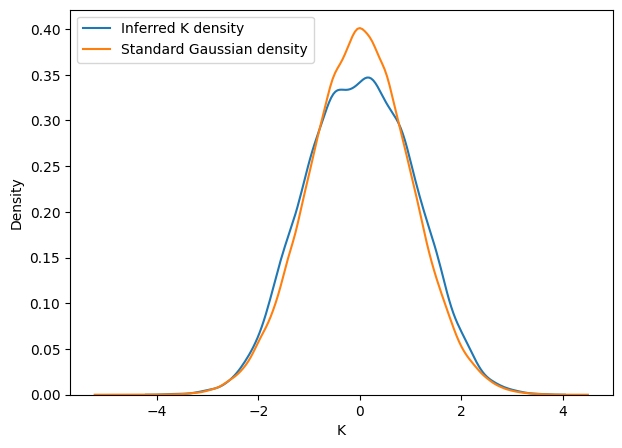

In [55]:
plt.figure(figsize=(7, 5))
sns.kdeplot(np.array(K_list_train), label="Inferred K density")
sns.kdeplot(np.random.randn(80000), label="Standard Gaussian density")
plt.xlabel("K")
plt.legend()
plt.show()

Predict FYA

In [31]:
train_U = pd.DataFrame({'K':torch.stack(K_list_train), 'ZFYA':train_tensor[:len(K_list_train),2]})
test_U = pd.DataFrame({'K':torch.stack(K_list_test), 'ZFYA':test_tensor[:len(K_list_test),2]})


# create and train model
fairK_model = LinearRegressionModel(train_U.shape[1]-1, 1)
# fairK_model.load_state_dict(torch.load(os.path.join(model_dir,'fairK_model.pt')))
fairK_validation_scores, fairK_train_losses = train(fairK_model, train_U, test_U, 'fairK_model', n_epochs=25, batch_size=20)

  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 1, validation score: 0.9367531662727886


  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 6, validation score: 0.9369015372947828


  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 11, validation score: 0.9364008181812407


  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 16, validation score: 0.9363717283457313


  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

Epoch 21, validation score: 0.9363821995175384


  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

Best validation score:0.9363717283457313


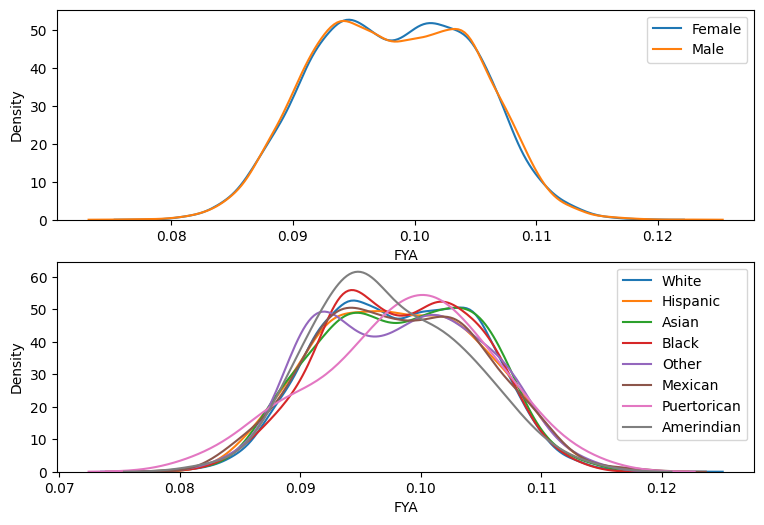

In [32]:

# Look at distribution of FYA on difference races and sex on train set
fit = train_trans.copy()
fit['FYA'] = fairK_model(torch.tensor(train_U.drop('ZFYA', axis=1).values, dtype=torch.float32)).detach().numpy()

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(9, 6)

for column in ohe_categories[0]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax1)
ax1.legend()

for column in ohe_categories[1]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax2)

ax2.legend()

plt.show()

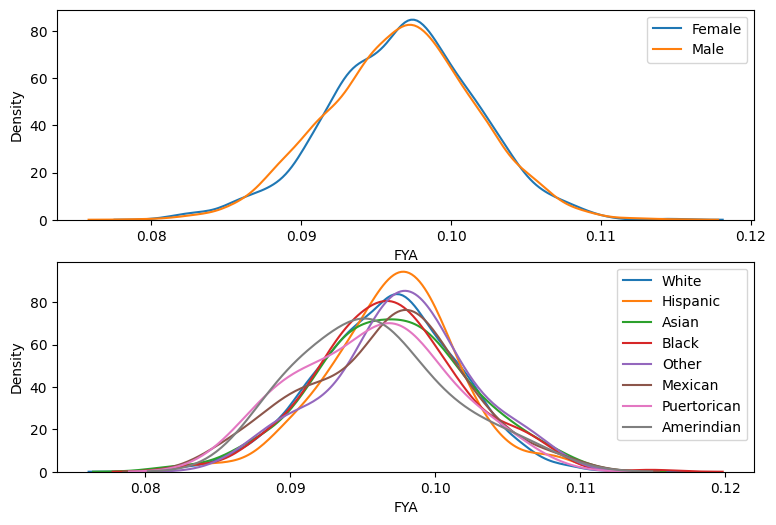

In [35]:

# Look at distribution of FYA on difference races and sex on train set
fit = test_trans.copy()
fit['FYA'] = fairK_model(torch.tensor(test_U.drop('ZFYA', axis=1).values, dtype=torch.float32)).detach().numpy()

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(9, 6)

for column in ohe_categories[0]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax1)
ax1.legend()

for column in ohe_categories[1]:
    data_filtered = fit[fit[column]==1]
    sns.kdeplot(data=data_filtered, x='FYA', label=column, ax=ax2)

ax2.legend()

plt.show()